<a id='sec0'></a>

# Writing n-class word extraction functions

<a href='#sec1'><b>1. Extraction by frequency differences between classes</b></a>
   - Thresholds for minimum fraction of documents appearing or per-doc frequency
   - Threshold with absolute difference (by subtraction) or relative/fold difference (by division)

<a href='#sec2'><b>2. Extraction by exclusive appearances in certain classes</b></a>
   - Threshold for minimum fraction of documents appearing or per-doc frequency
   
<a href='#sec3'><b>3. Classification by Random Forest Classifier</b></a>
   1. <a href='#sec3_1'>RFC with exclusive words</a>
   2. <a href='#sec3_2'>RFC with words selected by relative difference - fraction of docs appearing</a>

In [2]:
import csv
import json
import random
import re
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import mskcc_functions as ski
import feature_engineering as fe
import xgboost as xgb

from importlib import reload
from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from gensim import corpora, matutils, models, similarities
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%matplotlib inline

Using TensorFlow backend.
/usr/lib64/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
Slow version of gensim.models.doc2vec is being used


In [3]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])
train = class_train.merge(text_train, on='ID')

# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: Dep

In [4]:
with open('./data/classified_docs.json') as f1:
    classified_docs = json.load(f1)

with open('./data/classified_tokenized_docs.json') as f2:
    classified_tokenized_docs = json.load(f2)

with open('./data/classified_texts.json') as f3:
    classified_texts = json.load(f3)

with open('./data/classified_tokenized_texts.json') as f4:
    classified_tokenized_texts = json.load(f4)

with open('./data/average_per_document_appearances.json') as f5:
    ave_perdoc_apps = json.load(f5)
    
with open('./data/fraction_of_documents_with_appearance.json') as f6:
    app_freqs = json.load(f6)

with open("./data/unclassified_tokenized_docs.csv", "r") as f:
    reader = csv.reader(f)
    unclassified_tokenized_docs = list(reader)

In [5]:
%%time
fracdocs = pd.DataFrame(app_freqs).fillna(value=0)
n = 3000

top_words = []
for i in range(9):
    tops = fracdocs[class_labels[i]].sort_values(ascending=False).head(n)
    top_words.append(list(tops.index))

overlap1 = set(top_words[0])
for lis in top_words[1:]:
    overlap1.intersection_update(lis)
print('# intersecting words among top%d appearing words in each class: ', len(overlap1))
    
remove_list = []
for i in range(9):
    remove_words = [word for word in overlap1 \
                    if word in fracdocs[class_labels[i]] \
                    if fracdocs[class_labels[i]][word] > 0.5]
    remove_list.append(list(remove_words))

overlap2 = set(remove_list[0])
for lis in remove_list[1:]:
    overlap2.intersection_update(lis)
print('# intersecting words with >50% appearance: ', len(overlap2))

fracdocs_update1 = fracdocs.copy()
fracdocs_update1 = fracdocs_update1.drop(overlap2)
print('Table shape before removal: ', fracdocs.shape)
print('Table shape after removal:  ', fracdocs_update1.shape)

# intersecting words among top%d appearing words in each class:  1391
# intersecting words with >50% appearance:  287
Table shape before removal:  (125448, 9)
Table shape after removal:   (125161, 9)
CPU times: user 343 ms, sys: 7.94 ms, total: 351 ms
Wall time: 353 ms


In [6]:
fracdocs_update1.head()
fracdocs_update1.to_csv('./data/app_freqs_update1.csv')

In [6]:
perdoc_apps = pd.DataFrame(ave_perdoc_apps).fillna(value=0)

<a id='sec1'></a>
# 1. Extraction by fold difference  in frequency between classes
(<a href='#sec0'>Back to top</a>)

In [7]:
def getRelativeDifference(a, b, freq_threshold=0.05):
    if ((b != 0) and (a >= freq_threshold)):
        return (a / b)
    else:
        return 0

def getAbsoluteDifference(a, b, freq_threshold=0.05):
    if ((a >= b ) and (a >= freq_threshold)):
        return (a - b)
    else:
        return 0

def decideOnDifference(a, b, freq_threshold, min_difference, mode='relative'):
    if mode == 'relative':
        difference = getRelativeDifference(a, b, freq_threshold=freq_threshold)
        return (difference >= min_difference)
    elif mode == 'absolute':
        difference = getAbsoluteDifference(a, b, freq_threshold=freq_threshold)
        return (difference >= min_difference)
    else:
        print('ERROR: Invalid mode')
        return

def get_nClassWords(docs, doc_type='fraction_of_docs', mode='relative',
                    min_frequency=0.3, min_difference=1.5, print_result=True):
    '''
    This function looks at each word in each doc in the 'docs' and creates 
    a list containing frequency of appearance ('apps') for each class. The list is
    re-order in descending order, and the fold difference between the adjacent pair
    of frequencies are compared. If the fold difference is above a certain threshold
    ('fold_threshold), the word is classified into a designated class of words.
    When a word is classified as n-class word, it means that the freqs of app of the
    word in n (number of) classes are X fold (fold_threshold) higher than those of 
    other classes. freq_threshold is a cutoff freq of app to decide whether to 
    include the word or not in the list. 
    
    - Number of classes are assumed to be 9.
    - Use get_FoldDifference function to calculate fold difference
     
    INPUTS:
    ========
    frac_docs : DataFrame
        A list of lists containing fractions of docs a word appears in the class
    
    OUTPUTS:
    ========
    n_class_words : dictionary
        A dictionary whose keys are n-class_word labels. Values a lists of words
        in each of n classes of words
    '''
    min_freq = min_frequency
    min_d = min_difference
    mode = mode
    
    # Basic validation of input parameters
    if doc_type == 'fraction_of_docs':
        if ((min_freq < 0) or (min_freq > 1)):
            print('ERROR: freq_threshold must be between 0 and 1')
            return
        #else:
            #print('Doc Type: Fraction of Docs')
    if doc_type == 'per_doc_frequency':
        if (min_freq < 0):
            print('ERROR: freq_threshold must be above 0')
            return
        #else:
            #print('Doc Type: Per-doc Frequency')
    else:
        if not((doc_type == 'fraction_of_docs') or (doc_type == 'per_doc_frequency')):
            print('ERROR: Invalid Doc Type')
            return
    
    if not ((mode == 'relative') or (mode == 'absolute')):
        print('ERROR: Invalid Mode')
    
    if ((doc_type == 'fraction_of_docs') and (mode == 'relative')):
        if (min_freq*min_d) > 1:
            print('ERROR: Fold difference too high. Lower min_difference')
            return
            
    if ((doc_type == 'fraction_of_docs') and (mode == 'absolute')):
        if (min_freq + min_d) > 1:
            print('ERROR: Absolute difference too high. Lower min_difference')
            return
    
    ncw_labels = ['one_class_words', 'two_class_words', 'three_class_words', 
                  'four_class_words', 'five_class_words', 'six_class_words', 
                  'seven_class_words', 'eight_class_words','other_words']

    # Create a new dictionary to contain each n-class of words in list formats
    n_class_words = {}
    for i in range(9):
        n_class_words[ncw_labels[i]] = []

    # Get words for each n-class of words (might be a better way to do this?)
    for j, word in enumerate(docs.index):
        apps = np.array(docs.loc[word])
        apps[::-1].sort()
        if decideOnDifference(apps[0], apps[1], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[0]].append(word)
        elif decideOnDifference(apps[1], apps[2], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[1]].append(word)
        elif decideOnDifference(apps[2], apps[3], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[2]].append(word)
        elif decideOnDifference(apps[3], apps[4], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[3]].append(word)
        elif decideOnDifference(apps[4], apps[5], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[4]].append(word)
        elif decideOnDifference(apps[5], apps[6], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[5]].append(word)
        elif decideOnDifference(apps[6], apps[7], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[6]].append(word)
        elif decideOnDifference(apps[7], apps[8], 
                              freq_threshold=min_freq, min_difference=min_d, mode=mode):
            n_class_words[ncw_labels[7]].append(word)
        else:
            n_class_words[ncw_labels[8]].append(word)
    
    # Remove a list of words from one-class words
    one_class_remove_list = ['bunkyo', 'commonest', 'commonplac', 'concret', 'consol',
                             'conspicu', 'credenc', 'damage—unlik', 'drew', 'enumer', 'logo', 
                             'graduat','ibaraki', 'joshi', 'kaneda', 'kurumizaka', 'lesson', 
                             'matsui', 'minami', 'minato', 'montreal', 'newyork', 'ontario', 
                             'shirokanedai', 'sinai', 'taipei', 'wake', 'wise', 'yokohama']
    n_class_words['one_class_words'] = [word for word in n_class_words['one_class_words'] if len(word) > 2]
    
    if print_result:
        print('======== n-class words extractions by %s differecne ========' % mode)
        print('Input Type: %s' % doc_type)
        print('Minimum Difference = %.2f' % min_d)
        print('Minimum Frequency = %.2f' % min_freq)
        total = 0
        for i in range(9):
            print('# of words in %s: %d' % (ncw_labels[i], len(n_class_words[ncw_labels[i]])))
            total += len(n_class_words[ncw_labels[i]])
        print('Total # of words: %d' % total)
    
    return n_class_words

In [66]:
%%time
n_class_words = get_nClassWords(fracdocs_update1, doc_type='fraction_of_docs', mode='relative',
                                min_frequency=0.35, min_difference=1.4, print_result=True)
print('\n')
n_class_words = get_nClassWords(fracdocs_update1, doc_type='fraction_of_docs', mode='absolute',
                                min_frequency=0.35, min_difference=0.2, print_result=True)
print('\n')
n_class_words = get_nClassWords(perdoc_apps, doc_type='per_doc_frequency', mode='relative',
                                min_frequency=2, min_difference=5, print_result=True)
print('\n')
n_class_words = get_nClassWords(perdoc_apps, doc_type='per_doc_frequency', mode='absolute',
                                min_frequency=2, min_difference=3, print_result=True)

======== n-class words extractions by relative differecne ========
Minimum Difference = 1.400000
Minimum Frequency = 0.350000
# of words in one_class_words: 312
# of words in two_class_words: 117
# of words in three_class_words: 11
# of words in four_class_words: 14
# of words in five_class_words: 11
# of words in six_class_words: 6
# of words in seven_class_words: 25
# of words in eight_class_words: 69
# of words in other_words: 124581
Total # of words: 125146


======== n-class words extractions by absolute differecne ========
Minimum Difference = 0.200000
Minimum Frequency = 0.350000
# of words in one_class_words: 186
# of words in two_class_words: 56
# of words in three_class_words: 2
# of words in four_class_words: 2
# of words in five_class_words: 1
# of words in six_class_words: 1
# of words in seven_class_words: 2
# of words in eight_class_words: 16
# of words in other_words: 124885
Total # of words: 125151


======== n-class words extractions by relative differecne ========
Mi

In [67]:
%%time
n_class_words = get_nClassWords(perdoc_apps, doc_type='per_doc_frequency', mode='relative',
                                min_frequency=1, min_difference=5, print_result=True)

======== n-class words extractions by relative differecne ========
Minimum Difference = 5.000000
Minimum Frequency = 1.000000
# of words in one_class_words: 220
# of words in two_class_words: 77
# of words in three_class_words: 7
# of words in four_class_words: 4
# of words in five_class_words: 11
# of words in six_class_words: 3
# of words in seven_class_words: 0
# of words in eight_class_words: 4
# of words in other_words: 125105
Total # of words: 125431
CPU times: user 8.92 s, sys: 12.8 ms, total: 8.94 s
Wall time: 8.93 s


<a id='sec2'></a>
# 2. Extraction by exclusive appearance in certain classes
(<a href='#sec0'>Back to top</a>)

In [8]:
def get_nClassExclusiveWords(docs, min_frequency=0.2, print_result=True):
    '''
    This function looks at each word in each doc in the 'docs' and creates 
    a list containing frequency of appearance ('apps') for each class. Then,
    the number of non-zero freqs in the list is counted. That number is used
    to classified the word as n-class word. In this case, n-class word is a
    word that appears only in n number of classes. freq_threshold parameter 
    is a cutoff freq of app to decide whether to include the word or not in 
    the list. 
    
    - Number of classes are assumed to be 9
    - This function can be used for both 'fraction_of_docs' and 'perdoc_apps'
      types of inputs
    
    INPUTS:
    ========
    frac_docs : DataFrame
        A list of lists containing fractions of docs a word appears in the class
    
    OUTPUTS:
    ========
    n_class_words : dictionary
        A dictionary whose keys are n-class_word labels. Values a lists of words
        in each of n classes of words
        
    '''
    min_freq = min_frequency

    ncw_labels = ['one_class_words', 'two_class_words', 'three_class_words', 
                  'four_class_words', 'five_class_words', 'six_class_words', 
                  'seven_class_words', 'eight_class_words','other_words']

    # Create a new dictionary to contain each n-class of words in list formats
    n_class_words = {}
    for i in range(9):
        n_class_words[ncw_labels[i]] = []

    # Get words for each n-class of words
    for j, word in enumerate(docs.index):
        apps = np.array(docs.loc[word])
        num_nonzeros = np.count_nonzero(apps)
        if np.min(apps[np.nonzero(apps)]) >= min_freq:
            n_class_words[ncw_labels[(num_nonzeros-1)]].append(word)
        else:
            n_class_words[ncw_labels[8]].append(word)
    
    # Remove a list of words from one-class words
    one_class_remove_list = ['bunkyo', 'commonest', 'commonplac', 'concret', 'consol',
                             'conspicu', 'credenc', 'damage—unlik', 'drew', 'enumer', 'logo', 
                             'graduat','ibaraki', 'joshi', 'kaneda', 'kurumizaka', 'lesson', 
                             'matsui', 'minami', 'minato', 'montreal', 'newyork', 'ontario', 
                             'shirokanedai', 'sinai', 'taipei', 'wake', 'wise', 'yokohama']
    n_class_words['one_class_words'] = [word for word in n_class_words['one_class_words'] if len(word) > 2]
    
    if print_result:
        print('======== n-class words extractions by exclusive appearances ========')
        print('Minimum Frequency = %f' % min_freq)
        total = 0
        for i in range(9):
            print('# of words in %s: %d' % (ncw_labels[i], len(n_class_words[ncw_labels[i]])))
            total += len(n_class_words[ncw_labels[i]])
        print('Total # of words: %d' % total)
    
    return n_class_words

In [23]:
%%time
min_freq = 0.15
n_class_words = get_nClassExclusiveWords(fracdocs_update1, min_frequency=min_freq)

======== n-class words extractions by exclusive appearances ========
Minimum Frequency = 0.150000
# of words in one_class_words: 264
# of words in two_class_words: 4
# of words in three_class_words: 0
# of words in four_class_words: 0
# of words in five_class_words: 0
# of words in six_class_words: 0
# of words in seven_class_words: 0
# of words in eight_class_words: 3
# of words in other_words: 124890
Total # of words: 125161
CPU times: user 9.46 s, sys: 75.3 ms, total: 9.54 s
Wall time: 9.36 s


<a id='sec3'></a>
# 3. Classification with Random Forest Classifier
(<a href='#sec0'>Back to top</a>)

<a id='sec3_1'></a>
## 1. RFC with exclusive words
- Write a function to iterate over min_frequency space
- Try both with fraction of documents appearing and per-doc frequency

(<a href='#sec0'>Back to top</a>)

In [14]:
ncw_labels = ['one_class_words', 'two_class_words', 'three_class_words', 
                  'four_class_words', 'five_class_words', 'six_class_words', 
                  'seven_class_words', 'eight_class_words','other_words']

In [114]:
def RFC_nWordsExclusive(main_docs, freq_docs, classes, min_frequency=0.15, n_class=1):
    # Words to create features
    #print('Extracting exclusive words...')
    exclusive_words = get_nClassExclusiveWords(freq_docs, min_frequency=min_frequency,
                                               print_result=False)
    select_words = []
    for i in range(n_class):
        select_words += exclusive_words[ncw_labels[i]]
    if len(select_words) == 0:
        print('No words extraced. Process terminated.')
        return
    
    #print('%d words extracted...' % len(select_words))
        
    # pre-process the raw texts
    #print('Pre-processing texts...')
    unclf_docs2 = []
    for j, doc in enumerate(main_docs):
        doc = [word for word in doc if word in select_words]
        text = ' '.join(doc)
        unclf_docs2.append(text)
    
    # Vectroize by Frequency Counts
    #print('Vectorizating texts...')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unclf_docs2).toarray()
    
    # Run RFC on the data
    #print('Training the classifier...')
    X = X.astype(float)
    y = classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)
    rfc.fit(X_train, y_train)
    
    #print('Making predictions...')
    accuracy = accuracy_score(y_test, rfc.predict(X_test))
    lloss = log_loss(y_test, rfc.predict_proba(X_test), labels=list(range(1, 10)))
    
    #print('===== Prediction Result =====')
    print(' - Accuracyl: %.3f' % accuracy)
    print(' - Log Loss: %.3f' % lloss)
    
    return [accuracy, lloss]

Try with fraction of documents appearing (min_freq = 0.1 ~0.16, n_class = 1, 2)

In [113]:
%%time
params = []
metrics = {}
y = np.array(class_train.Class).astype(int).ravel()

for i in range(2):
    n_class = i + 1
    freq_space = np.linspace(0.1, 0.16, 7)
    for j, freq in enumerate(freq_space):
        print('===== Processing: min_freq=%.2f, n_class=%d =====' % (freq, n_class))
        param = (freq, n_class)
        params.append(param)
        scores = RFC_nWordsExclusive(unclassified_tokenized_docs, fracdocs_update1, y, min_frequency=freq, n_class=n_class)
        metrics[param] = scores
        print('\n')

===== Processing: min_freq=0.10, n_class=1 =====
Extracting exclusive words...
335 words extracted...
Pre-processing texts...
Vectorizating texts...
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.323
 - Log Loss: 1.776


===== Processing: min_freq=0.11, n_class=1 =====
Extracting exclusive words...
312 words extracted...
Pre-processing texts...
Vectorizating texts...
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.303
 - Log Loss: 1.762


===== Processing: min_freq=0.12, n_class=1 =====
Extracting exclusive words...
312 words extracted...
Pre-processing texts...
Vectorizating texts...
Training the classifier...
Making predictions...
===== Prediction Result =====
 - Accuracyl: 0.283
 - Log Loss: 1.771


===== Processing: min_freq=0.13, n_class=1 =====
Extracting exclusive words...
312 words extracted...
Pre-processing texts...
Vectorizating texts...
Training the classifier...
Making prediction

Try with per-doc frequency (min_freq = 0.5~2, n_class = 1, 2)

In [115]:
%%time
params = []
metrics = {}
y = np.array(class_train.Class).astype(int).ravel()

for i in range(2):
    n_class = i + 1
    freq_space = [0.5, 1, 1.5, 2]
    for j, freq in enumerate(freq_space):
        print('===== Processing: min_freq=%.2f, n_class=%d =====' % (freq, n_class))
        param = (freq, n_class)
        params.append(param)
        scores = RFC_nWordsExclusive(unclassified_tokenized_docs, perdoc_apps, y, min_frequency=freq, n_class=n_class)
        metrics[param] = scores
        print('\n')

===== Processing: min_freq=0.50, n_class=1 =====
 - Accuracyl: 0.295
 - Log Loss: 1.802


===== Processing: min_freq=1.00, n_class=1 =====
 - Accuracyl: 0.329
 - Log Loss: 1.746


===== Processing: min_freq=1.50, n_class=1 =====
 - Accuracyl: 0.271
 - Log Loss: 1.865


===== Processing: min_freq=2.00, n_class=1 =====
 - Accuracyl: 0.299
 - Log Loss: 1.786


===== Processing: min_freq=0.50, n_class=2 =====
 - Accuracyl: 0.293
 - Log Loss: 1.779


===== Processing: min_freq=1.00, n_class=2 =====
 - Accuracyl: 0.299
 - Log Loss: 1.797


===== Processing: min_freq=1.50, n_class=2 =====
 - Accuracyl: 0.293
 - Log Loss: 1.832


===== Processing: min_freq=2.00, n_class=2 =====
 - Accuracyl: 0.295
 - Log Loss: 1.799


CPU times: user 2min 23s, sys: 644 ms, total: 2min 23s
Wall time: 2min 23s


Looks like exclusive words don't seem to work or their frequencies are too low...
Try with TfidfVectorizer

In [117]:
# This version uses TfidfVectorizer
def RFC_nWordsExclusive2(main_docs, freq_docs, classes, min_frequency=0.15, n_class=1):
    # Words to create features
    #print('Extracting exclusive words...')
    exclusive_words = get_nClassExclusiveWords(freq_docs, min_frequency=min_frequency,
                                               print_result=False)
    select_words = []
    for i in range(n_class):
        select_words += exclusive_words[ncw_labels[i]]
    if len(select_words) == 0:
        print('No words extraced. Process terminated.')
        return
    
    print('%d words extracted...' % len(select_words))
        
    # pre-process the raw texts
    #print('Pre-processing texts...')
    unclf_docs2 = []
    for j, doc in enumerate(main_docs):
        doc = [word for word in doc if word in select_words]
        text = ' '.join(doc)
        unclf_docs2.append(text)
    
    # Vectroize by Frequency Counts
    #print('Vectorizating texts...')
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(unclf_docs2).toarray()
    
    # Run RFC on the data
    #print('Training the classifier...')
    X = X.astype(float)
    y = classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)
    rfc.fit(X_train, y_train)
    
    #print('Making predictions...')
    accuracy = accuracy_score(y_test, rfc.predict(X_test))
    lloss = log_loss(y_test, rfc.predict_proba(X_test), labels=list(range(1, 10)))
    
    #print('===== Prediction Result =====')
    print(' - Accuracyl: %.3f' % accuracy)
    print(' - Log Loss: %.3f' % lloss)
    
    return [accuracy, lloss]

In [118]:
%%time
params = []
metrics = {}
y = np.array(class_train.Class).astype(int).ravel()

for i in range(2):
    n_class = i + 1
    freq_space = np.linspace(0.1, 0.16, 7)
    for j, freq in enumerate(freq_space):
        print('===== Processing: min_freq=%.2f, n_class=%d =====' % (freq, n_class))
        param = (freq, n_class)
        params.append(param)
        scores = RFC_nWordsExclusive2(unclassified_tokenized_docs, fracdocs_update1, y, min_frequency=freq, n_class=n_class)
        metrics[param] = scores
        print('\n')

===== Processing: min_freq=0.10, n_class=1 =====
335 words extracted...
 - Accuracyl: 0.337
 - Log Loss: 1.743


===== Processing: min_freq=0.11, n_class=1 =====
312 words extracted...
 - Accuracyl: 0.303
 - Log Loss: 1.783


===== Processing: min_freq=0.12, n_class=1 =====
312 words extracted...
 - Accuracyl: 0.259
 - Log Loss: 1.807


===== Processing: min_freq=0.13, n_class=1 =====
312 words extracted...
 - Accuracyl: 0.331
 - Log Loss: 1.771


===== Processing: min_freq=0.14, n_class=1 =====
264 words extracted...
 - Accuracyl: 0.295
 - Log Loss: 1.818


===== Processing: min_freq=0.15, n_class=1 =====
264 words extracted...
 - Accuracyl: 0.301
 - Log Loss: 1.784


===== Processing: min_freq=0.16, n_class=1 =====
110 words extracted...
 - Accuracyl: 0.305
 - Log Loss: 1.812


===== Processing: min_freq=0.10, n_class=2 =====
348 words extracted...
 - Accuracyl: 0.285
 - Log Loss: 1.787


===== Processing: min_freq=0.11, n_class=2 =====
316 words extracted...
 - Accuracyl: 0.271
 - L

Still no good...

<a id='sec3_2'></a>
## 2. RFC with words selected by relative difference - fraction of docs appearing
- Write a function to iterate over min_frequency space
- Try both with fraction of documents appearing

(<a href='#sec0'>Back to top</a>)

In [126]:
# This version uses TfidfVectorizer
def RFC_nClassWords(main_docs, freq_docs, classes, vectorizer='count',
                    min_difference=1.5, min_frequency=0.35, n_class=1):
    # Words to create features
    #print('Extracting exclusive words...')
    nclass_words = get_nClassWords(freq_docs, doc_type='fraction_of_docs', mode='relative',
                                   min_frequency=min_frequency, min_difference=min_difference, print_result=False)
    select_words = []
    for i in range(n_class):
        select_words += nclass_words[ncw_labels[i]]
    if len(select_words) == 0:
        print('No words extraced. Process terminated.')
        return
    
    print('%d words extracted...' % len(select_words))
        
    # pre-process the raw texts
    #print('Pre-processing texts...')
    unclf_docs2 = []
    for j, doc in enumerate(main_docs):
        doc = [word for word in doc if word in select_words]
        text = ' '.join(doc)
        unclf_docs2.append(text)
    
    # Vectroize by Frequency Counts
    #print('Vectorizating texts...')
    if vectorizer == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unclf_docs2).toarray()
    
    # Run RFC on the data
    #print('Training the classifier...')
    X = X.astype(float)
    y = classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)
    rfc.fit(X_train, y_train)
    
    #print('Making predictions...')
    accuracy = accuracy_score(y_test, rfc.predict(X_test))
    lloss = log_loss(y_test, rfc.predict_proba(X_test), labels=list(range(1, 10)))
    
    #print('===== Prediction Result =====')
    print(' - Accuracyl: %.3f' % accuracy)
    print(' - Log Loss: %.3f' % lloss)
    
    return [accuracy, lloss]

In [124]:
%%time
params = []
metrics = {}
y = np.array(class_train.Class).astype(int).ravel()

min_freq = 0.35
for i in range(2):
    n_class = i + 1
    diff_space = [2, 1.8, 1.6, 1.4, 1.2]
    for j, diff in enumerate(diff_space):
        print('===== Processing: min_freq=%.2f, fold_diff=%.2f, n_class=%d =====' % (min_freq, diff, n_class))
        param = (min_freq, diff, n_class)
        params.append(param)
        scores = RFC_nClassWords(unclassified_tokenized_docs, fracdocs_update1, y, min_difference=diff, min_frequency=0.35, n_class=n_class)
        metrics[param] = scores
        print('\n')

===== Processing: min_freq=0.35, fold_diff=2.00, n_class=1 =====
116 words extracted...
 - Accuracyl: 0.605
 - Log Loss: 1.711


===== Processing: min_freq=0.35, fold_diff=1.80, n_class=1 =====
145 words extracted...
 - Accuracyl: 0.611
 - Log Loss: 1.378


===== Processing: min_freq=0.35, fold_diff=1.60, n_class=1 =====
214 words extracted...
 - Accuracyl: 0.611
 - Log Loss: 1.456


===== Processing: min_freq=0.35, fold_diff=1.40, n_class=1 =====
312 words extracted...
 - Accuracyl: 0.617
 - Log Loss: 1.716


===== Processing: min_freq=0.35, fold_diff=1.20, n_class=1 =====
599 words extracted...
 - Accuracyl: 0.629
 - Log Loss: 1.666


===== Processing: min_freq=0.35, fold_diff=2.00, n_class=2 =====
147 words extracted...
 - Accuracyl: 0.577
 - Log Loss: 1.754


===== Processing: min_freq=0.35, fold_diff=1.80, n_class=2 =====
187 words extracted...
 - Accuracyl: 0.629
 - Log Loss: 1.572


===== Processing: min_freq=0.35, fold_diff=1.60, n_class=2 =====
285 words extracted...
 - Accura

In [129]:
%%time
params = []
metrics = {}
y = np.array(class_train.Class).astype(int).ravel()

n_class = 1 
freqs = [0.3, 0.35, 0.4]
diff_space = [1.6, 1.5, 1.4]
for i, freq in enumerate(freqs):
    for j, diff in enumerate(diff_space):
        print('===== Processing: min_freq=%.2f, fold_diff=%.2f, n_class=%d =====' % (freq, diff, n_class))
        param = (freq, diff, n_class)
        params.append(param)
        scores = RFC_nClassWords(unclassified_tokenized_docs, fracdocs_update1, y, vectorizer='tfidf',
                                 min_difference=diff, min_frequency=freq, n_class=n_class)
        metrics[param] = scores
        print('\n')

===== Processing: min_freq=0.30, fold_diff=1.60, n_class=1 =====
283 words extracted...
 - Accuracyl: 0.625
 - Log Loss: 1.475


===== Processing: min_freq=0.30, fold_diff=1.50, n_class=1 =====
335 words extracted...
 - Accuracyl: 0.643
 - Log Loss: 1.597


===== Processing: min_freq=0.30, fold_diff=1.40, n_class=1 =====
414 words extracted...
 - Accuracyl: 0.603
 - Log Loss: 2.146


===== Processing: min_freq=0.35, fold_diff=1.60, n_class=1 =====
214 words extracted...
 - Accuracyl: 0.597
 - Log Loss: 1.549


===== Processing: min_freq=0.35, fold_diff=1.50, n_class=1 =====
248 words extracted...
 - Accuracyl: 0.597
 - Log Loss: 1.959


===== Processing: min_freq=0.35, fold_diff=1.40, n_class=1 =====
312 words extracted...
 - Accuracyl: 0.659
 - Log Loss: 1.269


===== Processing: min_freq=0.40, fold_diff=1.60, n_class=1 =====
133 words extracted...
 - Accuracyl: 0.637
 - Log Loss: 1.464


===== Processing: min_freq=0.40, fold_diff=1.50, n_class=1 =====
161 words extracted...
 - Accura

In [130]:
%%time
params = []
metrics = {}
y = np.array(class_train.Class).astype(int).ravel()

n_class = [1, 2, 3] 
freq = 0.35
diff = 1.4
for i, n in enumerate(n_class):
    print('===== Processing: min_freq=%.2f, fold_diff=%.2f, n_class=%d =====' % (freq, diff, n))
    param = (freq, diff, n)
    params.append(param)
    scores = RFC_nClassWords(unclassified_tokenized_docs, fracdocs_update1, y, vectorizer='tfidf',
                             min_difference=diff, min_frequency=freq, n_class=n)
    metrics[param] = scores
    print('\n')

===== Processing: min_freq=0.35, fold_diff=1.40, n_class=1 =====
312 words extracted...
 - Accuracyl: 0.613
 - Log Loss: 1.389


===== Processing: min_freq=0.35, fold_diff=1.40, n_class=2 =====
429 words extracted...
 - Accuracyl: 0.633
 - Log Loss: 1.370


===== Processing: min_freq=0.35, fold_diff=1.40, n_class=3 =====
440 words extracted...
 - Accuracyl: 0.597
 - Log Loss: 1.554


CPU times: user 4min 22s, sys: 95.1 ms, total: 4min 22s
Wall time: 4min 19s


minimum frequency of 0.35, fold difference of 1.4, and inclusion of 2-class words seems to be best, which is similar to what I got before...

## PCA & LDA

with Tfidf vectorizer

In [57]:
%%time
ncw_labels = ['one_class_words', 'two_class_words', 'three_class_words', 
                  'four_class_words', 'five_class_words', 'six_class_words', 
                  'seven_class_words', 'eight_class_words','other_words']

n = 2
freq = 0.35
diff = 1.4
min_freq = 0.15

nclass_words = get_nClassWords(fracdocs_update1, doc_type='fraction_of_docs', mode='relative',
                               min_frequency=freq, min_difference=diff, print_result=True)
nclass_words_excl = get_nClassExclusiveWords(fracdocs_update1, min_frequency=min_freq)

select_words = []
for i in range(n):
    select_words += nclass_words[ncw_labels[i]]
print('%d words extracted by fold difference' % len(select_words))

excl_words = nclass_words_excl[ncw_labels[0]] + nclass_words_excl[ncw_labels[1]]
print('%d exclusive words extracted' % len(excl_words))
select_words = select_words + excl_words

select_words = list(set(select_words))
print('%d unique words extracted in total' % len(select_words))

# pre-process the raw texts
print('Pre-processing texts...')
unclf_docs2 = []
for j, doc in enumerate(unclassified_tokenized_docs):
    doc = [word for word in doc if word in select_words]
    text = ' '.join(doc)
    unclf_docs2.append(text)

# Vectroize by Frequency Counts
print('Vectorizating texts...')
vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()

X = vectorizer.fit_transform(unclf_docs2).toarray()
X = X.astype(float)
y = np.array(class_train.Class).astype(int).ravel()

print(X.shape)
print(y.shape)

======== n-class words extractions by relative differecne ========
Input Type: fraction_of_docs
Minimum Difference = 1.40
Minimum Frequency = 0.35
# of words in one_class_words: 312
# of words in two_class_words: 117
# of words in three_class_words: 11
# of words in four_class_words: 14
# of words in five_class_words: 11
# of words in six_class_words: 6
# of words in seven_class_words: 25
# of words in eight_class_words: 69
# of words in other_words: 124581
Total # of words: 125146
======== n-class words extractions by exclusive appearances ========
Minimum Frequency = 0.150000
# of words in one_class_words: 264
# of words in two_class_words: 4
# of words in three_class_words: 0
# of words in four_class_words: 0
# of words in five_class_words: 0
# of words in six_class_words: 0
# of words in seven_class_words: 0
# of words in eight_class_words: 3
# of words in other_words: 124890
Total # of words: 125161
429 words extracted by fold difference
268 exclusive words extracted
697 unique wo

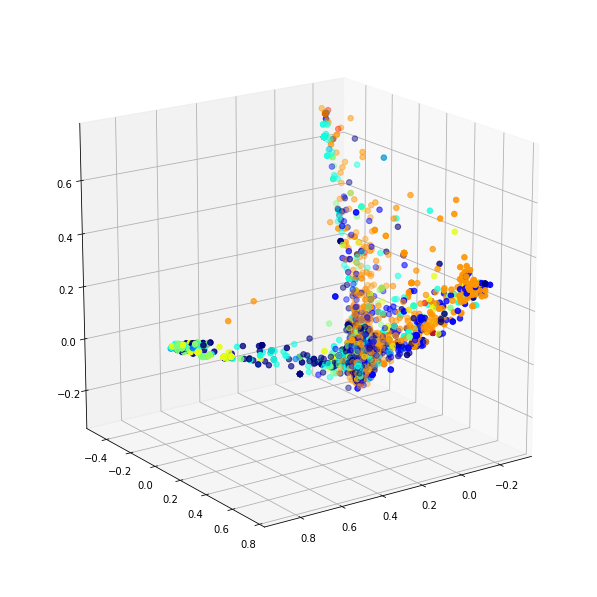

In [58]:
# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X)
pca_table1['x'] = pca.transform(X).T[0]
pca_table1['y'] = pca.transform(X).T[1]
pca_table1['z'] = pca.transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table1.x, pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

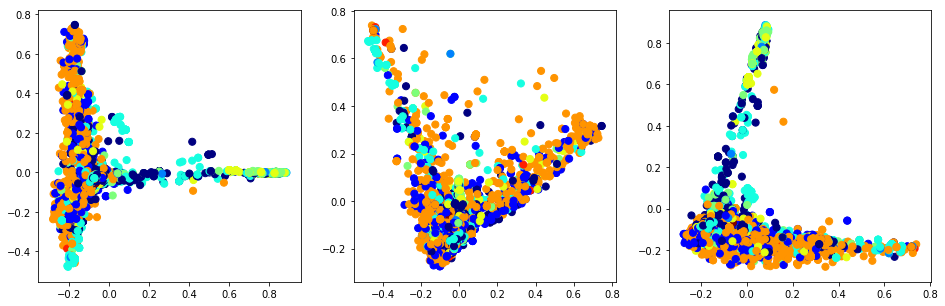

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table1.x, pca_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table1.z, pca_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

/usr/lib64/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


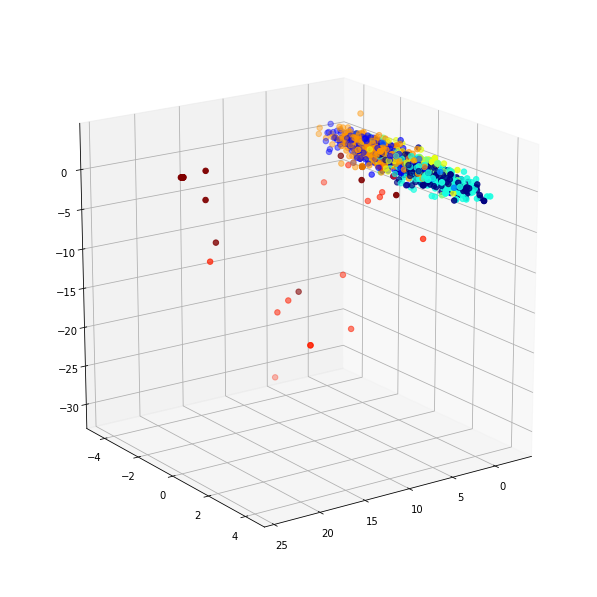

In [60]:
# Create a new table with ID as index
lda_table1 = pd.DataFrame(index=class_train.ID)
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X, y)
lda_table1['x'] = lda.transform(X).T[0]
lda_table1['y'] = lda.transform(X).T[1]
lda_table1['z'] = lda.transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(lda_table1.x, lda_table1.y, lda_table1.z, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

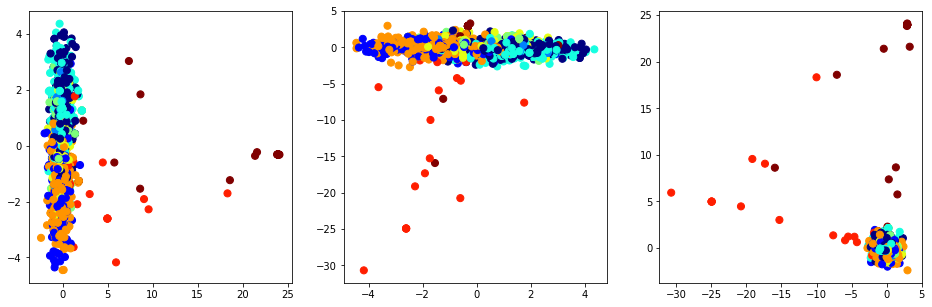

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(lda_table1.x, lda_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(lda_table1.y, lda_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(lda_table1.z, lda_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

In [62]:
%%time
pca = PCA()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, X_train_pca.shape)
print(X_test.shape, X_test_pca.shape)

rfc.fit(X_train_pca, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_pca))
lloss = log_loss(y_test, rfc.predict_proba(X_test_pca), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 707) (2822, 707)
(499, 707) (499, 707)
Accuracy 0.591
Log Loss 1.915
CPU times: user 5.12 s, sys: 29 ms, total: 5.15 s
Wall time: 2.02 s


In [63]:
%%time
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train.shape, X_train_lda.shape)
print(X_test.shape, X_test_lda.shape)

rfc.fit(X_train_lda, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_lda))
lloss = log_loss(y_test, rfc.predict_proba(X_test_lda), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

/usr/lib64/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/usr/lib64/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(2822, 707) (2822, 8)
(499, 707) (499, 8)
Accuracy 0.583
Log Loss 2.363
CPU times: user 1.5 s, sys: 30.9 ms, total: 1.53 s
Wall time: 1.37 s


with Count vectorizer, also with 2-class exclusive words

In [50]:
%%time
ncw_labels = ['one_class_words', 'two_class_words', 'three_class_words', 
                  'four_class_words', 'five_class_words', 'six_class_words', 
                  'seven_class_words', 'eight_class_words','other_words']

n = 2
freq = 0.35
diff = 1.4
min_freq = 0.15

nclass_words = get_nClassWords(fracdocs_update1, doc_type='fraction_of_docs', mode='relative',
                               min_frequency=freq, min_difference=diff, print_result=True)
nclass_words_excl = get_nClassExclusiveWords(fracdocs_update1, min_frequency=min_freq)

select_words = []
for i in range(n):
    select_words += nclass_words[ncw_labels[i]]
print('%d words extracted by fold difference' % len(select_words))

excl_words = nclass_words_excl[ncw_labels[0]] + nclass_words_excl[ncw_labels[1]]
print('%d exclusive words extracted' % len(excl_words))
select_words = select_words + excl_words

select_words = list(set(select_words))
print('%d unique words extracted in total' % len(select_words))

# pre-process the raw texts
print('Pre-processing texts...')
unclf_docs2 = []
for j, doc in enumerate(unclassified_tokenized_docs):
    doc = [word for word in doc if word in select_words]
    text = ' '.join(doc)
    unclf_docs2.append(text)

# Vectroize by Frequency Counts
print('Vectorizating texts...')
#vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(unclf_docs2).toarray()
X = X.astype(float)
y = np.array(class_train.Class).astype(int).ravel()

print(X.shape)
print(y.shape)

======== n-class words extractions by relative differecne ========
Input Type: fraction_of_docs
Minimum Difference = 1.40
Minimum Frequency = 0.35
# of words in one_class_words: 312
# of words in two_class_words: 117
# of words in three_class_words: 11
# of words in four_class_words: 14
# of words in five_class_words: 11
# of words in six_class_words: 6
# of words in seven_class_words: 25
# of words in eight_class_words: 69
# of words in other_words: 124581
Total # of words: 125146
======== n-class words extractions by exclusive appearances ========
Minimum Frequency = 0.150000
# of words in one_class_words: 264
# of words in two_class_words: 4
# of words in three_class_words: 0
# of words in four_class_words: 0
# of words in five_class_words: 0
# of words in six_class_words: 0
# of words in seven_class_words: 0
# of words in eight_class_words: 3
# of words in other_words: 124890
Total # of words: 125161
429 words extracted by fold difference
268 exclusive words extracted
697 unique wo

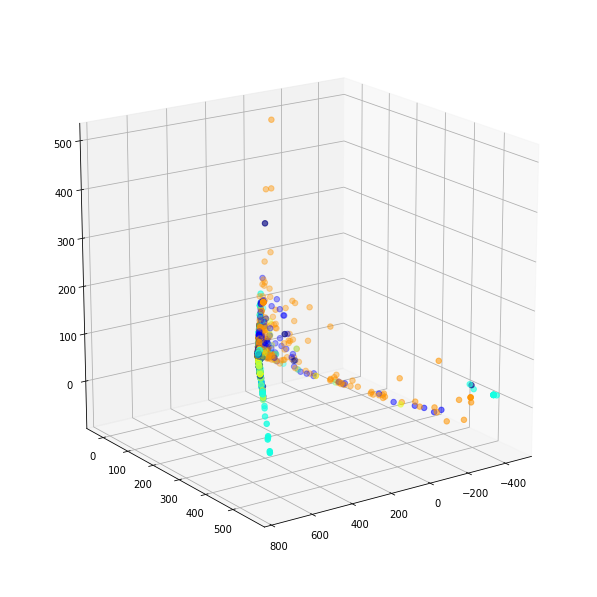

In [51]:
# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X)
pca_table1['x'] = pca.transform(X).T[0]
pca_table1['y'] = pca.transform(X).T[1]
pca_table1['z'] = pca.transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table1.x, pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

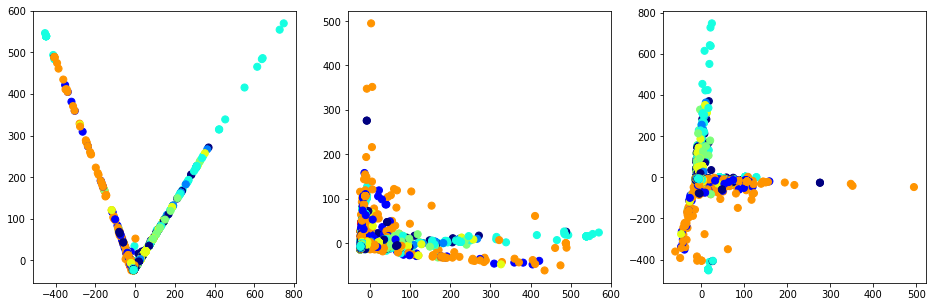

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table1.x, pca_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table1.z, pca_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

/usr/lib64/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


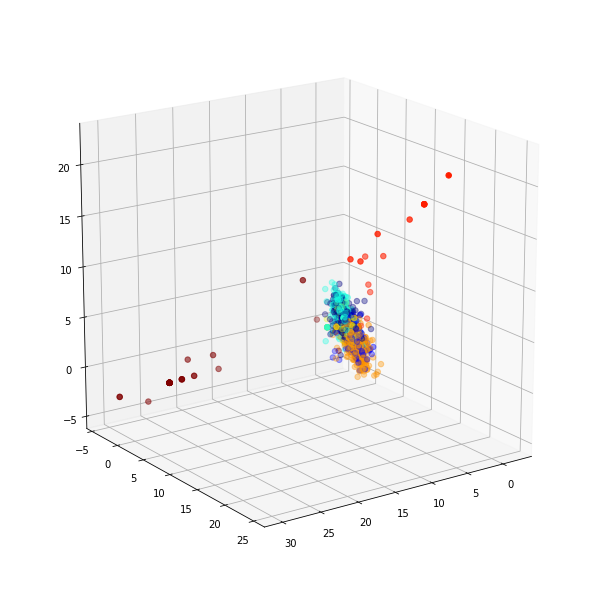

In [53]:
# Create a new table with ID as index
lda_table1 = pd.DataFrame(index=class_train.ID)
lda = LinearDiscriminantAnalysis(n_components=3, solver='svd')
lda.fit(X, y)
lda_table1['x'] = lda.transform(X).T[0]
lda_table1['y'] = lda.transform(X).T[1]
lda_table1['z'] = lda.transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(lda_table1.x, lda_table1.y, lda_table1.z, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

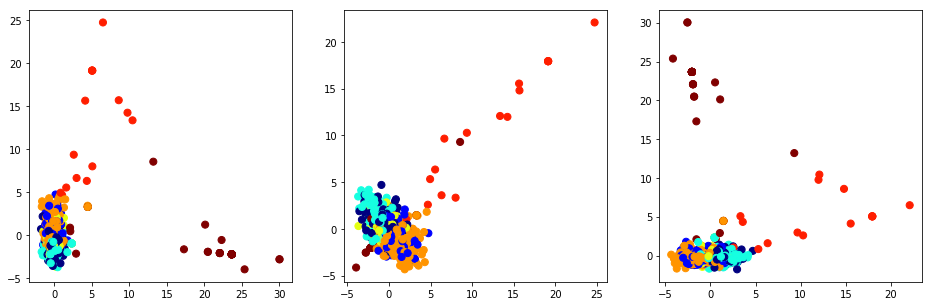

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(lda_table1.x, lda_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(lda_table1.y, lda_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(lda_table1.z, lda_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

In [55]:
%%time
pca = PCA()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape, X_train_pca.shape)
print(X_test.shape, X_test_pca.shape)

rfc.fit(X_train_pca, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_pca))
lloss = log_loss(y_test, rfc.predict_proba(X_test_pca), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

(2822, 707) (2822, 707)
(499, 707) (499, 707)
Accuracy 0.633
Log Loss 1.739
CPU times: user 5.12 s, sys: 19.9 ms, total: 5.13 s
Wall time: 2.01 s


In [56]:
%%time
lda = LinearDiscriminantAnalysis()
rfc = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=7, random_state=33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print(X_train.shape, X_train_lda.shape)
print(X_test.shape, X_test_lda.shape)

rfc.fit(X_train_lda, y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test_lda))
lloss = log_loss(y_test, rfc.predict_proba(X_test_lda), labels=list(range(1, 10)))

print('Accuracy %.3f' % accuracy)
print('Log Loss %.3f' % lloss)

/usr/lib64/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(2822, 707) (2822, 8)
(499, 707) (499, 8)
Accuracy 0.571
Log Loss 2.655
CPU times: user 1.54 s, sys: 17 ms, total: 1.56 s
Wall time: 1.31 s
